<a href="https://colab.research.google.com/github/pooja251096/Cardiovascular-Risk-Prediction/blob/main/Pooja_AlmaBetter_ML_Classification_CardioVascularRisk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
!pip install CatBoost
!pip install imbalanced-learn

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from collections import Counter
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
# mount drive and give path of dataset
data = pd.read_csv("/content/drive/MyDrive/Classification_cardiovascular/data_cardiovascular_risk.csv")

In [4]:
data.sample(5)

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
2621,2621,49,3.0,F,NO,0.0,1.0,0,1,0,300.0,131.0,88.0,26.85,70.0,73.0,1
2591,2591,62,2.0,F,NO,0.0,0.0,0,1,0,326.0,160.0,90.0,33.70,72.0,84.0,0
2004,2004,58,1.0,F,NO,0.0,0.0,0,1,0,200.0,158.0,101.0,23.06,85.0,77.0,1
493,493,63,2.0,M,YES,43.0,0.0,0,0,0,230.0,127.0,82.0,19.97,70.0,67.0,0
750,750,46,2.0,M,YES,20.0,0.0,0,1,0,238.0,140.5,92.5,26.97,75.0,83.0,0


In [5]:
data.tail()

,id,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
3385,3385,60,1.0,F,NO,0.0,0.0,0,0,0,261.0,123.5,79.0,29.28,70.0,103.0,0
3386,3386,46,1.0,F,NO,0.0,0.0,0,0,0,199.0,102.0,56.0,21.96,80.0,84.0,0
3387,3387,44,3.0,M,YES,3.0,0.0,0,1,0,352.0,164.0,119.0,28.92,73.0,72.0,1
3388,3388,60,1.0,M,NO,0.0,NaN,0,1,0,191.0,167.0,105.0,23.01,80.0,85.0,0
3389,3389,54,3.0,F,NO,0.0,0.0,0,0,0,288.0,124.0,77.0,29.88,79.0,92.0,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3390 entries, 0 to 3389
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               3390 non-null   int64  
 1   age              3390 non-null   int64  
 2   education        3303 non-null   float64
 3   sex              3390 non-null   object 
 4   is_smoking       3390 non-null   object 
 5   cigsPerDay       3368 non-null   float64
 6   BPMeds           3346 non-null   float64
 7   prevalentStroke  3390 non-null   int64  
 8   prevalentHyp     3390 non-null   int64  
 9   diabetes         3390 non-null   int64  
 10  totChol          3352 non-null   float64
 11  sysBP            3390 non-null   float64
 12  diaBP            3390 non-null   float64
 13  BMI              3376 non-null   float64
 14  heartRate        3389 non-null   float64
 15  glucose          3086 non-null   float64
 16  TenYearCHD       3390 non-null   int64  
dtypes: float64(9),

In [7]:
data.isna().sum()

id                   0
age                  0
education           87
sex                  0
is_smoking           0
cigsPerDay          22
BPMeds              44
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             38
sysBP                0
diaBP                0
BMI                 14
heartRate            1
glucose            304
TenYearCHD           0
dtype: int64

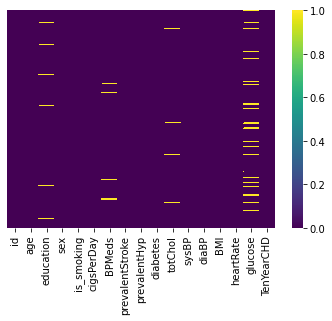

In [8]:
sns.heatmap(data.isnull(), yticklabels=False, cmap="viridis")


##Dealing with null values

In [9]:
data['glucose'] = data['glucose'].fillna(data['glucose'].median())
data['BPMeds'] = data['BPMeds'].fillna(data['BPMeds'].median())
data['heartRate'] = data['heartRate'].fillna(data['heartRate'].median())
data['BMI'] = data['BMI'].fillna(data['BMI'].median())
data['totChol'] = data['totChol'].fillna(data['totChol'].median())
data['education'] = data['education'].fillna(data['education'].median())



In [10]:
data.dropna(inplace=True)

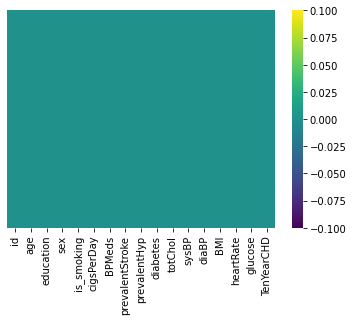

In [11]:
sns.heatmap(data.isnull(), yticklabels=False, cmap="viridis")

In [12]:
data.isnull().sum()

id                 0
age                0
education          0
sex                0
is_smoking         0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
TenYearCHD         0
dtype: int64

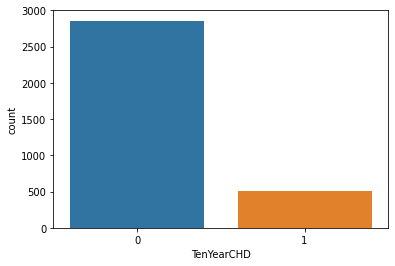

In [13]:
sns.countplot(x="TenYearCHD", data=data)

In [14]:
data.columns

Index(['id', 'age', 'education', 'sex', 'is_smoking', 'cigsPerDay', 'BPMeds',
       'prevalentStroke', 'prevalentHyp', 'diabetes', 'totChol', 'sysBP',
       'diaBP', 'BMI', 'heartRate', 'glucose', 'TenYearCHD'],
      dtype='object')

In [15]:
data.drop("id", axis=1, inplace=True)
data.drop_duplicates(inplace=True)

In [16]:
data.shape

(3368, 16)

here shape confirms that there are no duplicates and total columns reduced to 16

In [17]:
data.describe()

,age,education,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
count,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000,3368.000000,3368.00000,3368.000000,3368.000000,3368.000000,3368.000000
mean,49.543646,1.971200,9.069477,0.029691,0.006532,0.315914,0.025831,236.991686,132.601395,82.88465,25.796737,75.974762,81.692993,0.151425
std,8.603941,1.005805,11.879078,0.169759,0.080569,0.464948,0.158656,44.951744,22.300647,12.02176,4.114976,11.966154,23.198838,0.358516
min,32.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,107.000000,83.500000,48.00000,15.960000,45.000000,40.000000,0.000000
25%,42.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,206.000000,117.000000,74.50000,23.030000,68.000000,72.000000,0.000000
50%,49.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,234.000000,128.500000,82.00000,25.380000,75.000000,78.000000,0.000000
75%,56.000000,3.000000,20.000000,0.000000,0.000000,1.000000,0.000000,264.000000,144.000000,90.00000,28.025000,83.000000,85.000000,0.000000
max,70.000000,4.000000,70.000000,1.000000,1.000000,1.000000,1.000000,696.000000,295.000000,142.50000,56.800000,143.000000,394.000000,1.000000


In [18]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3368 entries, 0 to 3389
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              3368 non-null   int64  
 1   education        3368 non-null   float64
 2   sex              3368 non-null   object 
 3   is_smoking       3368 non-null   object 
 4   cigsPerDay       3368 non-null   float64
 5   BPMeds           3368 non-null   float64
 6   prevalentStroke  3368 non-null   int64  
 7   prevalentHyp     3368 non-null   int64  
 8   diabetes         3368 non-null   int64  
 9   totChol          3368 non-null   float64
 10  sysBP            3368 non-null   float64
 11  diaBP            3368 non-null   float64
 12  BMI              3368 non-null   float64
 13  heartRate        3368 non-null   float64
 14  glucose          3368 non-null   float64
 15  TenYearCHD       3368 non-null   int64  
dtypes: float64(9), int64(5), object(2)
memory usage: 447.3+ KB


In [19]:
## Encoding Assortment with numerical values
data['sex']=data['sex'].apply(lambda x: 1 if x=='M' else 0)
data['is_smoking']=data['is_smoking'].apply(lambda x: 1 if x=='YES' else 0)

In [20]:
data.head()

,age,education,sex,is_smoking,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,64,2.0,0,1,3.0,0.0,0,0,0,221.0,148.0,85.0,25.38,90.0,80.0,1
1,36,4.0,1,0,0.0,0.0,0,1,0,212.0,168.0,98.0,29.77,72.0,75.0,0
2,46,1.0,0,1,10.0,0.0,0,0,0,250.0,116.0,71.0,20.35,88.0,94.0,0
3,50,1.0,1,1,20.0,0.0,0,1,0,233.0,158.0,88.0,28.26,68.0,94.0,1
4,64,1.0,0,1,30.0,0.0,0,0,0,241.0,136.5,85.0,26.42,70.0,77.0,0


## Exploratory Data Analysis

In [21]:
#ns.pairplot(data)

In [22]:
#data.plot(kind='box', subplots=True, layout=(2,7),sharex=False,sharey=False, figsize=(20, 10), color='deeppink')

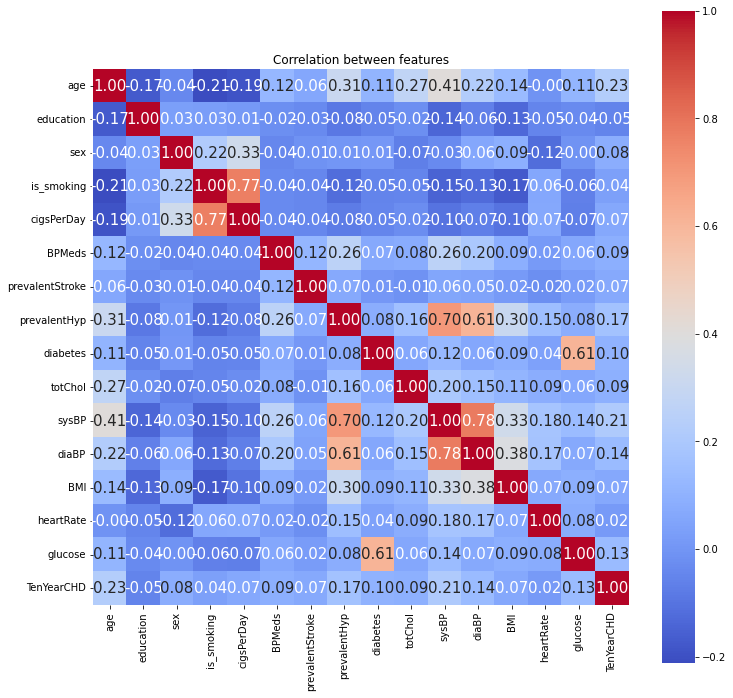

In [23]:
# Correlation
df_corr = data.corr()

plt.figure(figsize=(12, 12))
sns.heatmap(df_corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           cmap= 'coolwarm')
plt.title('Correlation between features');


In [24]:
data.drop("is_smoking", axis=1, inplace=True)
data.drop("glucose", axis=1, inplace=True)
data.drop("sysBP", axis=1, inplace=True)
data.drop("prevalentHyp", axis=1, inplace=True)


data.head()


,age,education,sex,cigsPerDay,BPMeds,prevalentStroke,diabetes,totChol,diaBP,BMI,heartRate,TenYearCHD
0,64,2.0,0,3.0,0.0,0,0,221.0,85.0,25.38,90.0,1
1,36,4.0,1,0.0,0.0,0,0,212.0,98.0,29.77,72.0,0
2,46,1.0,0,10.0,0.0,0,0,250.0,71.0,20.35,88.0,0
3,50,1.0,1,20.0,0.0,0,0,233.0,88.0,28.26,68.0,1
4,64,1.0,0,30.0,0.0,0,0,241.0,85.0,26.42,70.0,0


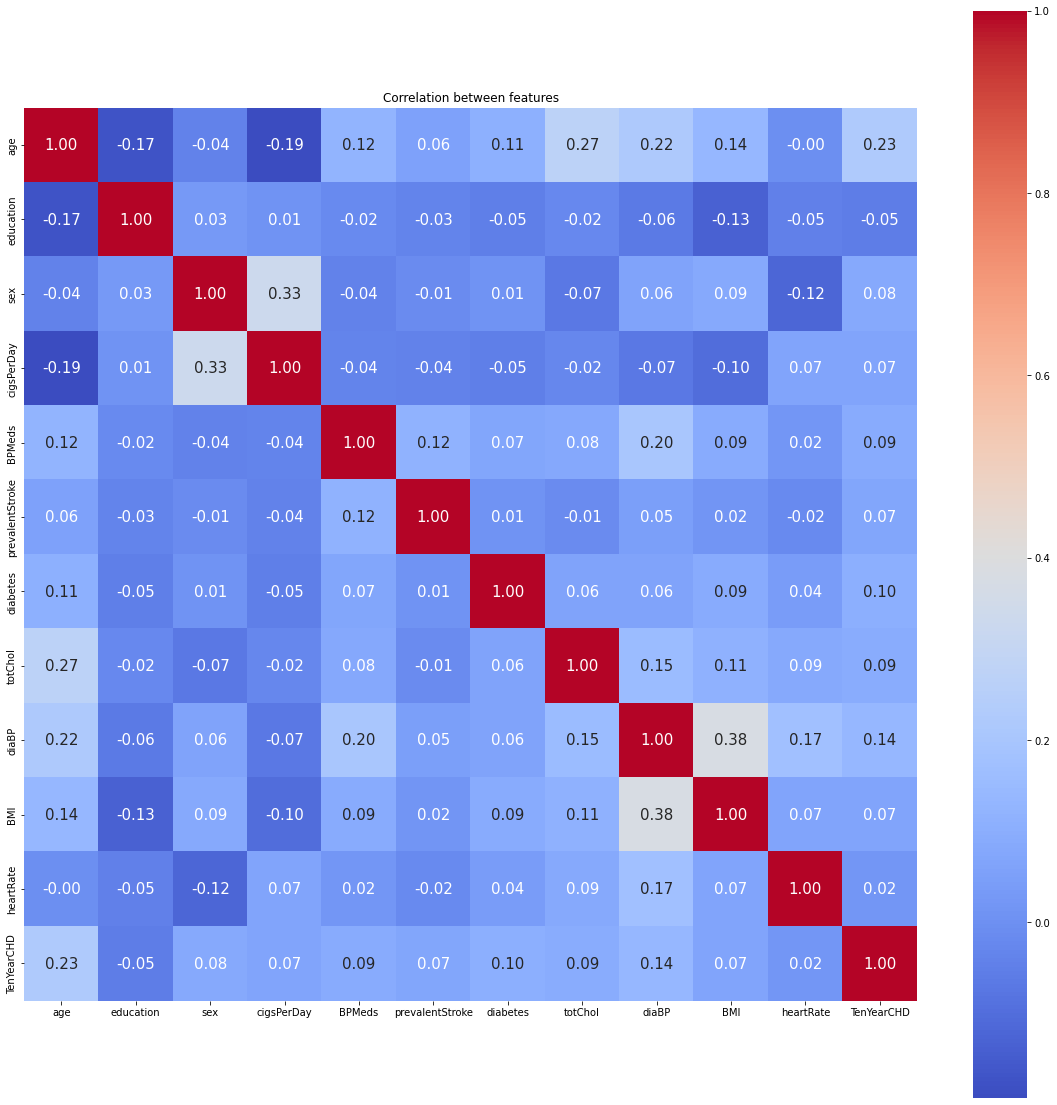

In [25]:
# Correlation
df_corr = data.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(df_corr, cbar = True,  square = True, annot=True, fmt= '.2f',annot_kws={'size': 15},
           cmap= 'coolwarm')
plt.title('Correlation between features');

##Dealing with object type variables 

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3368 entries, 0 to 3389
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   age              3368 non-null   int64  
 1   education        3368 non-null   float64
 2   sex              3368 non-null   int64  
 3   cigsPerDay       3368 non-null   float64
 4   BPMeds           3368 non-null   float64
 5   prevalentStroke  3368 non-null   int64  
 6   diabetes         3368 non-null   int64  
 7   totChol          3368 non-null   float64
 8   diaBP            3368 non-null   float64
 9   BMI              3368 non-null   float64
 10  heartRate        3368 non-null   float64
 11  TenYearCHD       3368 non-null   int64  
dtypes: float64(7), int64(5)
memory usage: 342.1 KB


## Data prepation to modeling

Splitting target variable from independent variables

In [27]:
target_variable = 'TenYearCHD'
X = data.drop([target_variable], axis=1).values
y = data[target_variable].values

In [28]:
X

array([[ 64.  ,   2.  ,   0.  , ...,  85.  ,  25.38,  90.  ],
       [ 36.  ,   4.  ,   1.  , ...,  98.  ,  29.77,  72.  ],
       [ 46.  ,   1.  ,   0.  , ...,  71.  ,  20.35,  88.  ],
       ...,
       [ 44.  ,   3.  ,   1.  , ..., 119.  ,  28.92,  73.  ],
       [ 60.  ,   1.  ,   1.  , ..., 105.  ,  23.01,  80.  ],
       [ 54.  ,   3.  ,   0.  , ...,  77.  ,  29.88,  79.  ]])

In [29]:
y

array([1, 0, 0, ..., 1, 0, 0])

In [30]:
#SMOTE
num_before = dict(Counter(y))
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(X,y)

print('Original dataset shape', len(data))
print('Resampled dataset shape', len(y_smote))
num_after =dict(Counter(y_smote))

Original dataset shape 3368
Resampled dataset shape 5716


In [31]:
print(num_before, num_after)

{1: 510, 0: 2858} {1: 2858, 0: 2858}


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


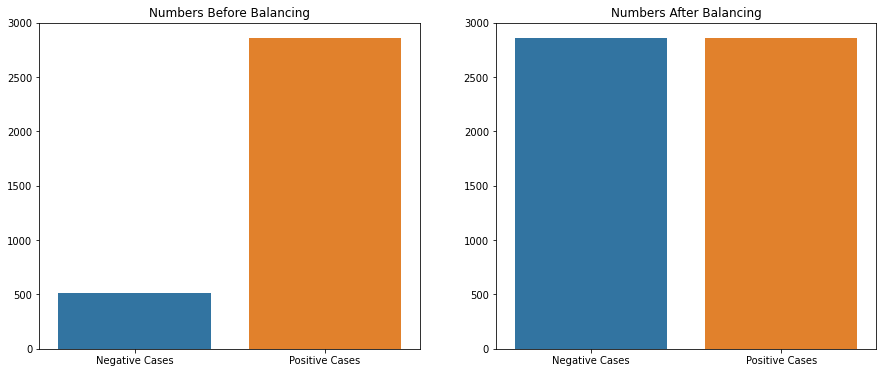

In [32]:
labels = ["Negative Cases","Positive Cases"]
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.barplot(labels, list(num_before.values()))
plt.title("Numbers Before Balancing")
plt.subplot(1,2,2)
sns.barplot(labels, list(num_after.values()))
plt.title("Numbers After Balancing")
plt.show()

Splitting train and test data

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_smote, y_smote, test_size=0.2, random_state=0)

In [34]:
X_train

array([[5.32257331e+01, 2.50693339e+00, 2.53466695e-01, ...,
        8.77604001e+01, 2.41615185e+01, 9.67742669e+01],
       [5.92545199e+01, 1.25451995e+00, 8.48399827e-02, ...,
        1.00033380e+02, 3.28468573e+01, 7.12364402e+01],
       [4.20000000e+01, 1.00000000e+00, 0.00000000e+00, ...,
        6.70000000e+01, 2.42300000e+01, 7.20000000e+01],
       ...,
       [4.20000000e+01, 1.00000000e+00, 0.00000000e+00, ...,
        7.90000000e+01, 2.13100000e+01, 7.00000000e+01],
       [4.60000000e+01, 1.00000000e+00, 1.00000000e+00, ...,
        9.40000000e+01, 2.63100000e+01, 9.80000000e+01],
       [4.70000000e+01, 1.00000000e+00, 0.00000000e+00, ...,
        8.50000000e+01, 2.70500000e+01, 7.50000000e+01]])

In [35]:
y_train

array([1, 1, 0, ..., 1, 0, 0])

In [36]:
X_test

array([[ 56.        ,   3.        ,   0.        , ...,  82.        ,
         26.82      ,  80.        ],
       [ 43.38382235,   2.        ,   0.        , ...,  73.        ,
         21.97423342,  80.46127412],
       [ 36.        ,   2.        ,   1.        , ...,  94.5       ,
         36.52      ,  65.        ],
       ...,
       [ 57.        ,   4.        ,   1.        , ...,  78.        ,
         29.02      ,  72.        ],
       [ 36.        ,   1.        ,   0.        , ...,  62.        ,
         20.79      ,  75.        ],
       [ 56.30688407,   1.24482872,   0.75517128, ..., 105.18277337,
         25.20489328,  66.24482872]])

In [37]:
y_test

array([0, 1, 0, ..., 0, 0, 1])

Feature Scaling X_train and X_test

In [38]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.transform(X_test)

In [39]:
X_train_scaled

array([[ 0.22182236,  0.64540765, -0.45478504, ...,  0.27694394,
        -0.45862222,  1.78221446],
       [ 0.93876757, -0.69665305, -0.81299234, ...,  1.26377907,
         1.75813966, -0.42032636],
       [-1.11314533, -0.96939143, -0.99321468, ..., -1.3923403 ,
        -0.44114367, -0.35447222],
       ...,
       [-1.11314533, -0.96939143, -0.99321468, ..., -0.42745471,
        -1.18641623, -0.52696464],
       [-0.63746408, -0.96939143,  1.13104722, ...,  0.77865228,
         0.08973541,  1.8879293 ],
       [-0.51854377, -0.96939143, -0.99321468, ...,  0.05498809,
         0.27860586, -0.09573358]])

In [40]:
X_test_scaled

array([[ 0.55173904,  1.17376778, -0.99321468, ..., -0.18623331,
         0.21990288,  0.33549748],
       [-0.94858074,  0.10218817, -0.99321468, ..., -0.9098975 ,
        -1.01688371,  0.37528063],
       [-1.8266672 ,  0.10218817,  1.13104722, ...,  0.81885584,
         2.69563706, -0.9581957 ],
       ...,
       [ 0.67065935,  2.24534738,  1.13104722, ..., -0.50786184,
         0.7814096 , -0.35447222],
       [-1.8266672 , -0.96939143, -0.99321468, ..., -1.79437596,
        -1.319136  , -0.09573358],
       [ 0.58823379, -0.70703797,  0.6109669 , ...,  1.67782702,
        -0.19232134, -0.85083394]])

Here is a data ready to be trained and tested, using any machine learning classification algorithm. 

##K-Nearest Neighbors (K-NN)

Training the K-NN model on the Training set

In [41]:
from sklearn.neighbors import KNeighborsClassifier
classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train_scaled, y_train)

KNeighborsClassifier()

Making the Confusion Matrix

In [45]:
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn

(522, 391, 187, 44)

In [46]:
accuracy_score_KNNClassifier = accuracy_score(y_test, y_pred)
print(accuracy_score_KNNClassifier)

0.7980769230769231


Calculating accuracy score

In [47]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.68      0.77       578
           1       0.74      0.92      0.82       566

    accuracy                           0.80      1144
   macro avg       0.82      0.80      0.80      1144
weighted avg       0.82      0.80      0.80      1144



#hyperparameter optimization

In [48]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
import numpy as np
grid_params = { 'n_neighbors' : [5,7,9,11,13],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
gs = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv=5, n_jobs = -1)

In [49]:
# fit the model on our train set
g_res = gs.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


In [50]:
g_res.best_params_

{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

In [51]:
# find the best score
g_res.best_score_


0.8541134268393298

In [52]:
# use the best hyperparameters
knn = KNeighborsClassifier(n_neighbors = 5, weights = 'distance',metric = 'manhattan')
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier(metric='manhattan', weights='distance')

In [53]:
# get a prediction
y_hat = knn.predict(X_train_scaled)
y_knn = knn.predict(X_test_scaled)

In [54]:
accuracy_score_KNNClassifier = accuracy_score(y_test, y_knn)
print(accuracy_score_KNNClassifier)

0.8627622377622378


In [55]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_knn).ravel()
tp, tn, fp, fn


(542, 445, 133, 24)

In [56]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_knn))

              precision    recall  f1-score   support

           0       0.95      0.77      0.85       578
           1       0.80      0.96      0.87       566

    accuracy                           0.86      1144
   macro avg       0.88      0.86      0.86      1144
weighted avg       0.88      0.86      0.86      1144



In [57]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, y_knn)

0.7260419399515561

##Support Vector Machine (SVM)

Training the SVM model on the Training set

In [58]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'linear', random_state = 0)
classifier.fit(X_train_scaled, y_train)

SVC(kernel='linear', random_state=0)

Making the Confusion Matrix

In [59]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
tp, tn, fp, fn

(410, 354, 224, 156)

Calculating accuracy score

In [60]:
accuracy_score_SVM = accuracy_score(y_test, y_pred)
print(accuracy_score_SVM)

0.6678321678321678


Classification report

In [61]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.61      0.65       578
           1       0.65      0.72      0.68       566

    accuracy                           0.67      1144
   macro avg       0.67      0.67      0.67      1144
weighted avg       0.67      0.67      0.67      1144



In [62]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
# fitting the model for grid search
grid.fit(X_train_scaled, y_train )

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.696 total time=   1.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.692 total time=   1.1s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.658 total time=   1.1s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.722 total time=   1.1s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.724 total time=   1.1s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.703 total time=   0.9s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.677 total time=   0.9s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.662 total time=   0.9s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.686 total time=   0.9s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.702 total time=   0.9s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.692 total time=   1.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [63]:
# print best parameter after tuning
print(grid.best_params_)
 
# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)

{'C': 10, 'gamma': 1, 'kernel': 'rbf'}
SVC(C=10, gamma=1)


In [64]:
grid_predictions = grid.predict(X_test_scaled)
 
# print classification report
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.90      0.86      0.88       578
           1       0.86      0.90      0.88       566

    accuracy                           0.88      1144
   macro avg       0.88      0.88      0.88      1144
weighted avg       0.88      0.88      0.88      1144



In [65]:
from sklearn.metrics import confusion_matrix, accuracy_score
y_pred = classifier.predict(X_test_scaled)
tn, fp, fn, tp = confusion_matrix(y_test, grid_predictions).ravel()
tp, tn, fp, fn

(512, 495, 83, 54)

In [66]:
from sklearn.metrics import cohen_kappa_score
cohen_kappa_score(y_test, grid_predictions)

0.760590488876397